<a href="https://colab.research.google.com/github/rwanghs/kvp-converter/blob/main/kVpConverter_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pydicom
# !pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

# import pydicom
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from tqdm import tqdm # visual progress bar
np.set_printoptions(precision=20)

In [ ]:
def orthanc_to_numpy(dcms):
    """
    dcms:   list of .dcm image files
    --------------------------------
    returns a list of the image files as numpy arrays
    """
    data_dcms = map(pydicom.dcmread, dcms)

    images = []
    for data in data_dcms:
        pixel_array = data.pixel_array
        rescale_slope = getattr(data, 'RescaleSlope', 1) # default is 1 if slope not found
        rescale_intercept = getattr(data, 'RescaleIntercept', 0) # default is 0 if intercept not found
        image = pixel_array * rescale_slope + rescale_intercept # correct HU in 2D numpy array
        images.append(image)

    return images

def mask_image(images, center=[256,256], radius=200):
    """
    images:    list of (512 x 512) 2D numpy arrays
    """
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = distance < radius
    images_copy = images.copy()
    for idx in range(len(images_copy)):
        images_copy[idx][~mask] = np.nan
    return images_copy

In [ ]:
def HU_to_LAC(HU, MAC_water):
    density_water = 1 # g/mL
    LAC_water = density_water * MAC_water
    return HU/1000*LAC_water + LAC_water

def hausdorff(T_vertices, point):
    """
    T_vertices:     [vertex1, vertex2, vertex3]
    vertex:         (x, y)
    point:          [ptx, pty]
    """
    def find_closest_vertex(x1,y1, x2,y2, ptx,pty):
        """ helper function """
        dist1 = np.sqrt((x1 - ptx) ** 2 + (y1 - pty) ** 2)
        dist2 = np.sqrt((x2 - ptx) ** 2 + (y2 - pty) ** 2)
        if dist1 < dist2:
            return dist1, [x1,y1]
        else:
            return dist2, [x2,y2]
    tol = 1e-3  # tolerance for floating-point comparisons
    dist = np.inf
    proj_point = None
    ptx, pty = point
    # loop through the three triangle edges to find min distance to the outside measured point
    # this can result in (a) projection point is on the triangle edge
    # or (b) projection point is on the extension line from the endpoints of the edge
    for i in range(len(T_vertices)):
        for j in range(i+1, len(T_vertices)):
            x1, y1 = T_vertices[i]
            x2, y2 = T_vertices[j]
            # check if the triangle edge is vertical or horizontal
            if np.abs(x1 - x2) < tol: # edge is vertical
                x0 = x1
                y0 = pty
                # check if the projection point [x0, y0] is on the triangle edge
                if min(y1,y2) < y0 < max(y1,y2):
                    dist_from_line = np.abs(x0 - ptx)
                    proj_point_from_line = [x0, y0]
                else:
                    # the projection is outside the edge but on the extension line, so take the closest endpoint
                    dist_from_line, proj_point_from_line = find_closest_vertex(x1,y1, x2,y2, ptx,pty)

            elif np.abs(y1 - y2) < tol: # edge is horizontal
                x0 = ptx
                y0 = y1
                if min(x1,x2) < x0 < max(x1,x2):
                    dist_from_line = np.abs(y0 - pty)
                    proj_point_from_line = [x0, y0]
                else:
                    dist_from_line, proj_point_from_line = find_closest_vertex(x1,y1, x2,y2, ptx,pty)

            else: # edge is neither vertical nor horizontal
                m1 = (y2 - y1) / (x2 - x1)
                m2 = -1 / m1
                # point of projection on the extended line:
                x0 = (m1*x1-y1-m2*ptx+pty)/(m1-m2)
                y0 = m2*(x0-ptx)+pty
                if min(x1, x2) < x0 < max(x1, x2) and min(y1, y2) < y0 < max(y1, y2):
                    dist_from_line = np.sqrt((x0-ptx)**2 + (y0-pty)**2)
                    proj_point_from_line = [x0, y0]
                else:
                    dist_from_line, proj_point_from_line = find_closest_vertex(x1,y1, x2,y2, ptx,pty)

            if dist_from_line < dist:
                dist = dist_from_line
                proj_point = proj_point_from_line
    return [dist, proj_point]

def interpolate_edge(vertex1, vertex2, num_points=100):
    x1, y1 = vertex1
    x2, y2 = vertex2
    all_xs = []
    all_ys = []
    for i in range(num_points + 1):
        t = i / num_points
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        all_xs.append(x)
        all_ys.append(y)
    return [all_xs, all_ys]

In [ ]:
def add(a, b):
    return a+b

In [ ]:
def ROI_mask(map, center=[256,256], radius=200):
    """
    images:    list of (512 x 512) 2D numpy arrays
    """
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = distance < radius
    map_copy = map.copy()
    map_copy[~mask] = np.nan
    return map_copy
def ROI_mask_rect(map, center=[256,256], side=200):
    """
    images:    list of (512 x 512) 2D numpy arrays
    """
    mask = np.zeros((512,512))
    # mask.asbool()
    mask[center[1]-side:center[1]+side, center[0]-side:center[0]+side] = 1
    # distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    # mask = distance < radius
    map_copy = map.copy()
    map_copy = map_copy*mask
    map_copy = np.where(mask==1, map_copy, np.nan)
    # map_copy[] = np.nan
    return map_copy

def ROI_mask_rect0(map, center=[256,256], side=200):
    """
    images:    list of (512 x 512) 2D numpy arrays
    """
    mask = np.zeros((512,512))
    # mask.asbool()
    mask[center[1]-side:center[1]+side, center[0]-side:center[0]+side] = 1
    # distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    # mask = distance < radius
    map_copy = map.copy()
    map_copy = map_copy*mask
    # map_copy = np.where(mask==1, map_copy, np.nan)

    return map_copy

In [ ]:
def create_annulus_mask(center=[256,256], inner_radius=0, outer_radius=200):
    """
    Creates a boolean mask for an annulus (ring) shape.

    Args:
        shape (tuple): Shape of the output array (rows, cols).
        center (tuple): Coordinates of the center of the annulus (x, y).
        inner_radius (float): Inner radius of the annulus.
        outer_radius (float): Outer radius of the annulus.

    Returns:
        numpy.ndarray: A boolean array where True values represent the annulus.
    """

    # Create coordinate grid
    x, y = np.meshgrid(np.arange(512), np.arange(512))

    # Calculate distance from center
    distances = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    # Create annulus mask
    mask = (distances >= inner_radius) & (distances <= outer_radius)

    return mask
def save_material_array(filename, array, dtype):
    # reshaping back into original bytes
    array_bytes = array.astype(dtype).tobytes()
    # add .vf if not included
    if filename.split(".")[-1] != "vf":
      filename = filename + ".vf"

    with open(filename, "wb") as f:
      f.write(array_bytes)

In [ ]:
from matplotlib.patches import Circle
from IPython.display import display, clear_output
import ipywidgets as widgets
from scipy import stats

# Global variable to store iodine PCA results
measured_HUs_pca_iodine = None

class IodinePCAAnalysis:
    def __init__(self, lambda2_filled):
        global measured_HUs_pca_iodine  # Declare as global
        self.image_iodine = (lambda2_filled)  # Scale and transpose for visualization
        self.default_values_iodine = [
            (384, 256, 22),
            (355, 340, 22),
            (278, 381, 22),
              # First circle
            (191, 366, 22),  # Fourth circle
            (135, 300, 22),  # Fifth circle
            (135, 212, 22),  # 6th circle
            (191, 145, 22),  # 7th circle
            (278, 130, 22),  # 8th circle
            (355, 174, 22),
              # 9th circle
        ]
        self.colors_iodine = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'black', 'black', 'black']
        measured_HUs_pca_iodine = None  # Initialize globally
        self.measured_HUs_pca_iodine = []  # Local copy for calculations
        self.num_circles_iodine = len(self.default_values_iodine)
        self.setup_widgets()
        self.output_iodine = widgets.Output()

    def update_image_iodine(self, change=None):
        with self.output_iodine:
            clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(self.image_iodine, vmin=self.image_iodine.min(), vmax=self.image_iodine.max())
            # ax.imshow(self.image_iodine, vmin=self.image_iodine.min(), vmax=50, cmap="gray")

            ax.set_title('Iodine Concentration Map with Circles (PCA)', fontsize=14)
            for i, (x_slider, y_slider, radius_slider) in enumerate(zip(self.x_sliders_iodine, self.y_sliders_iodine, self.radius_sliders_iodine)):
                circle = Circle((x_slider.value, y_slider.value), radius_slider.value, color=self.colors_iodine[i], fill=False)
                ax.add_patch(circle)
                ax.text(x_slider.value, y_slider.value, str(i + 1), color='white', fontsize=12)
            plt.axis('off')
            plt.show()

    def calculate_and_plot_iodine(self, button):
        global measured_HUs_pca_iodine  # Declare as global to save results
        self.measured_HUs_pca_iodine = []
        ground_truth_values_iodine = np.array([20.0, 15.0, 10.0, 5.0, 2.5, 1.0])  # Known iodine values

        for i, (x_slider, y_slider, radius_slider) in enumerate(zip(self.x_sliders_iodine, self.y_sliders_iodine, self.radius_sliders_iodine)):
            xx, yy = np.ogrid[:self.image_iodine.shape[0], :self.image_iodine.shape[1]]
            mask = (xx - y_slider.value)**2 + (yy - x_slider.value)**2 <= radius_slider.value**2
            mean_hu = self.image_iodine[mask].mean()
            self.measured_HUs_pca_iodine.append(mean_hu)
            print(f"Iodine - Mean value inside circle {i + 1}: {mean_hu:.2f}")

        self.measured_HUs_pca_iodine = np.array(self.measured_HUs_pca_iodine)
        measured_HUs_pca_iodine = self.measured_HUs_pca_iodine  # Save results globally

        # Bland-Altman and Correlation Analysis
        averages = (self.measured_HUs_pca_iodine + ground_truth_values_iodine) / 2
        differences = self.measured_HUs_pca_iodine - ground_truth_values_iodine

        slope, intercept, r_value, p_value, std_err = stats.linregress(ground_truth_values_iodine, self.measured_HUs_pca_iodine)
        regression_line = slope * ground_truth_values_iodine + intercept

        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        # Bland-Altman plot
        axs[0].scatter(averages, differences, c='red', marker='o')
        axs[0].axhline(np.mean(differences), color='blue', linestyle='--')
        axs[0].axhline(np.mean(differences) + 1.96 * np.std(differences), color='blue', linestyle='--')
        axs[0].axhline(np.mean(differences) - 1.96 * np.std(differences), color='blue', linestyle='--')
        axs[0].set_xlabel('Average of Calculated and Known Concentration Values')
        axs[0].set_ylabel('Difference between Calculated and Known Concentration Values')
        axs[0].grid(True)

        # Correlation plot
        axs[1].scatter(ground_truth_values_iodine, self.measured_HUs_pca_iodine, c='red', marker='o')
        axs[1].plot(ground_truth_values_iodine, regression_line, color='blue', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}, r = {r_value:.4f}')
        axs[1].plot(ground_truth_values_iodine, ground_truth_values_iodine, color='green', linestyle='--', label='Unity Line')
        axs[1].set_title('Iodine (PCA)')
        axs[1].set_xlabel('Known Concentration Values (mg/cc)')
        axs[1].set_ylabel('Calculated Concentration Values (mg/cc)')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    def setup_widgets(self):
        self.x_sliders_iodine = [
            widgets.IntSlider(value=x, min=0, max=self.image_iodine.shape[1] - 1, description=f'X{i + 1}')
            for i, (x, y, r) in enumerate(self.default_values_iodine)
        ]
        self.y_sliders_iodine = [
            widgets.IntSlider(value=y, min=0, max=self.image_iodine.shape[0] - 1, description=f'Y{i + 1}')
            for i, (x, y, r) in enumerate(self.default_values_iodine)
        ]
        self.radius_sliders_iodine = [
            widgets.IntSlider(value=r, min=1, max=50, description=f'Radius{i + 1}')
            for i, (x, y, r) in enumerate(self.default_values_iodine)
        ]
        self.calculate_button_iodine = widgets.Button(description='Calculate and Plot Iodine')
        self.calculate_button_iodine.on_click(self.calculate_and_plot_iodine)
        for slider in self.x_sliders_iodine + self.y_sliders_iodine + self.radius_sliders_iodine:
            slider.observe(self.update_image_iodine, 'value')

    def display(self):
        slider_rows = widgets.VBox([
            widgets.HBox([self.x_sliders_iodine[i], self.y_sliders_iodine[i], self.radius_sliders_iodine[i]])
            for i in range(self.num_circles_iodine)
        ])
        display(slider_rows, self.calculate_button_iodine, self.output_iodine)
        self.update_image_iodine()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Digital Phantom

In [ ]:
path = "/content/drive/MyDrive/MMD/Hamid/Hamid2kVpProof/"
os.listdir(path)

['rod_phantom_hamid-1734052175670.ppm',
 'Iodineonlyrod_inserts_140kVp_512x512x1.raw',
 'new_iodine_90kVp_512x512x1-1734394310413.raw',
 'full_90kVp_512x512x1-dilutediodine.raw',
 'full_140kVp_512x512x1-dilutediodine.raw',
 'phantom.ppm',
 'full_140kVp_512x512x1.raw',
 'full_90kVp_512x512x1.raw',
 '90kVp_omni.raw',
 '140kVp_omni.raw',
 'OmSalBl_full_90kVp_512x512x1_noBlrod.raw',
 'OmSalBl_full_140kVp_512x512x1_noBlrod.raw',
 'OmSalBl_fullblood_90kVp_512x512x1.raw',
 'OmSalBl_fullblood_140kVp_512x512x1.raw',
 'fullblood_90kVp_512x512x1.raw',
 'fullblood_140kVp_512x512x1.raw']

In [ ]:
lowE_raw = path+"fullblood_90kVp_512x512x1.raw"
highE_raw = path+"fullblood_140kVp_512x512x1.raw"
# Iodine_raw = path+'Iodineonlyrod_inserts_140kVp_512x512x1.raw'
# Inserts_raw = path+'rod_inserts_140kVp_512x512x1.raw'
#
lowE_file, highE_file = np.fromfile(lowE_raw, dtype=np.float32), np.fromfile(highE_raw, dtype=np.float32)
# Iodine_raw, Inserts_raw = np.fromfile(Iodine_raw, dtype=np.float32), np.fromfile(Inserts_raw, dtype=np.float32)

#
lowE_HU, highE_HU = np.reshape(lowE_file, (512, 512, 1)), np.reshape(highE_file, (512, 512, 1))
# Iodinemap_HU, Insertmap_HU = np.reshape(Iodine_raw, (512, 512, 1)), np.reshape(Inserts_raw, (512, 512, 1))

In [ ]:
lowE_analysis = IodinePCAAnalysis(lowE_HU)
lowE_analysis.display()

Button(description='Calculate and Plot Iodine', style=ButtonStyle())

Output()

Iodine - Mean value inside circle 1: 954.13
Iodine - Mean value inside circle 2: 71.76
Iodine - Mean value inside circle 3: 807.57
Iodine - Mean value inside circle 4: 663.78
Iodine - Mean value inside circle 5: 518.97
Iodine - Mean value inside circle 6: 372.18
Iodine - Mean value inside circle 7: 220.44
Iodine - Mean value inside circle 8: 142.95
Iodine - Mean value inside circle 9: 95.56


ValueError: operands could not be broadcast together with shapes (9,) (6,) 

In [ ]:
highE_analysis = IodinePCAAnalysis(highE_HU)
highE_analysis.display()

Button(description='Calculate and Plot Iodine', style=ButtonStyle())

Output()

Iodine - Mean value inside circle 1: 534.37
Iodine - Mean value inside circle 2: 64.32
Iodine - Mean value inside circle 3: 455.72
Iodine - Mean value inside circle 4: 380.41
Iodine - Mean value inside circle 5: 305.22
Iodine - Mean value inside circle 6: 226.74
Iodine - Mean value inside circle 7: 144.68
Iodine - Mean value inside circle 8: 101.11
Iodine - Mean value inside circle 9: 75.80


ValueError: operands could not be broadcast together with shapes (9,) (6,) 

In [ ]:
print(lowE_analysis.measured_HUs_pca_iodine)

[954.1327   71.76157 807.568   663.7762  518.9695  372.17868 220.44164
 142.95273  95.55603]


In [ ]:
IodineROI = ROI_mask(highE_HU, center=[85,256], radius=15)
# Inserts = ROI_mask(Inserts_HU, center=[256,256], radius=200

In [ ]:
IodineBloodhighROI = ROI_mask(highE_HU, center=[256,425], radius=25)
BloodhighROI =ROI_mask(highE_HU, center=[256,85], radius=25)
IodinehighROI = ROI_mask(highE_HU, center=[85,256], radius=25)

In [ ]:
plt.imshow(highE_HU)
plt.imshow(IodineBloodhighROI, cmap = 'jet')
plt.imshow(BloodhighROI, cmap = 'jet')
plt.imshow(IodinehighROI, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
# Iodine_HU = 1037.230
# Iodine_HU = 43283

# Blood_HU = 72.224

In [ ]:
# Iodine_highE_HU = np.nanmean(IodinehighROI)
# IodineBlood_highE_HU = np.nanmean(IodineBloodhighROI)
# Blood_highE_HU = np.nanmean(BloodhighROI)
# print(Iodine_highE_HU)
# print(Blood_highE_HU)
# print(IodineBlood_highE_HU)

99.047485
59.19171
79.8755


In [ ]:
volFractIodine = 0.5157702824
# volFractIodine = 0.02

volFractBlood = 1-volFractIodine
CTcalc140 = volFractIodine*Iodine_highE_HU + volFractBlood*Blood_highE_HU
print(volFractIodine*Iodine_highE_HU)
print(volFractBlood*Blood_highE_HU)
print(CTcalc140)

51.085749490785254
28.66238570796675
79.74813519875201


In [ ]:
volFractBlood

0.4842297176

In [ ]:
percerr = (CTcalc-IodineBlood_highE_HU)/IodineBlood_highE_HU *100
print(percerr)

-0.15945857696309462


In [ ]:
#Same calculation with 90 kVp
IodineBloodlowROI = ROI_mask(lowE_HU, center=[256,425], radius=25)
BloodlowROI =ROI_mask(lowE_HU, center=[256,85], radius=25)
IodinelowROI = ROI_mask(lowE_HU, center=[85,256], radius=25)

Iodine_lowE_HU = np.nanmean(IodinelowROI)
IodineBlood_lowE_HU = np.nanmean(IodineBloodlowROI)
Blood_lowE_HU = np.nanmean(BloodlowROI)

volFractIodine = 0.5157702824
volFractBlood = 1-volFractIodine

CTcalc90 = volFractIodine*Iodine_lowE_HU + volFractBlood*Blood_lowE_HU

percerror = (CTcalc-IodineBlood_lowE_HU)/IodineBlood_lowE_HU *100

print('HU of mixture =', IodineBlood_lowE_HU)
print('Calculation of CT number =', CTcalc90)
print('Percent error =', percerror,'%')

HU of mixture = 116.43464
Calculation of CT number = 117.9645244192428
Percent error = -31.508238528166576 %


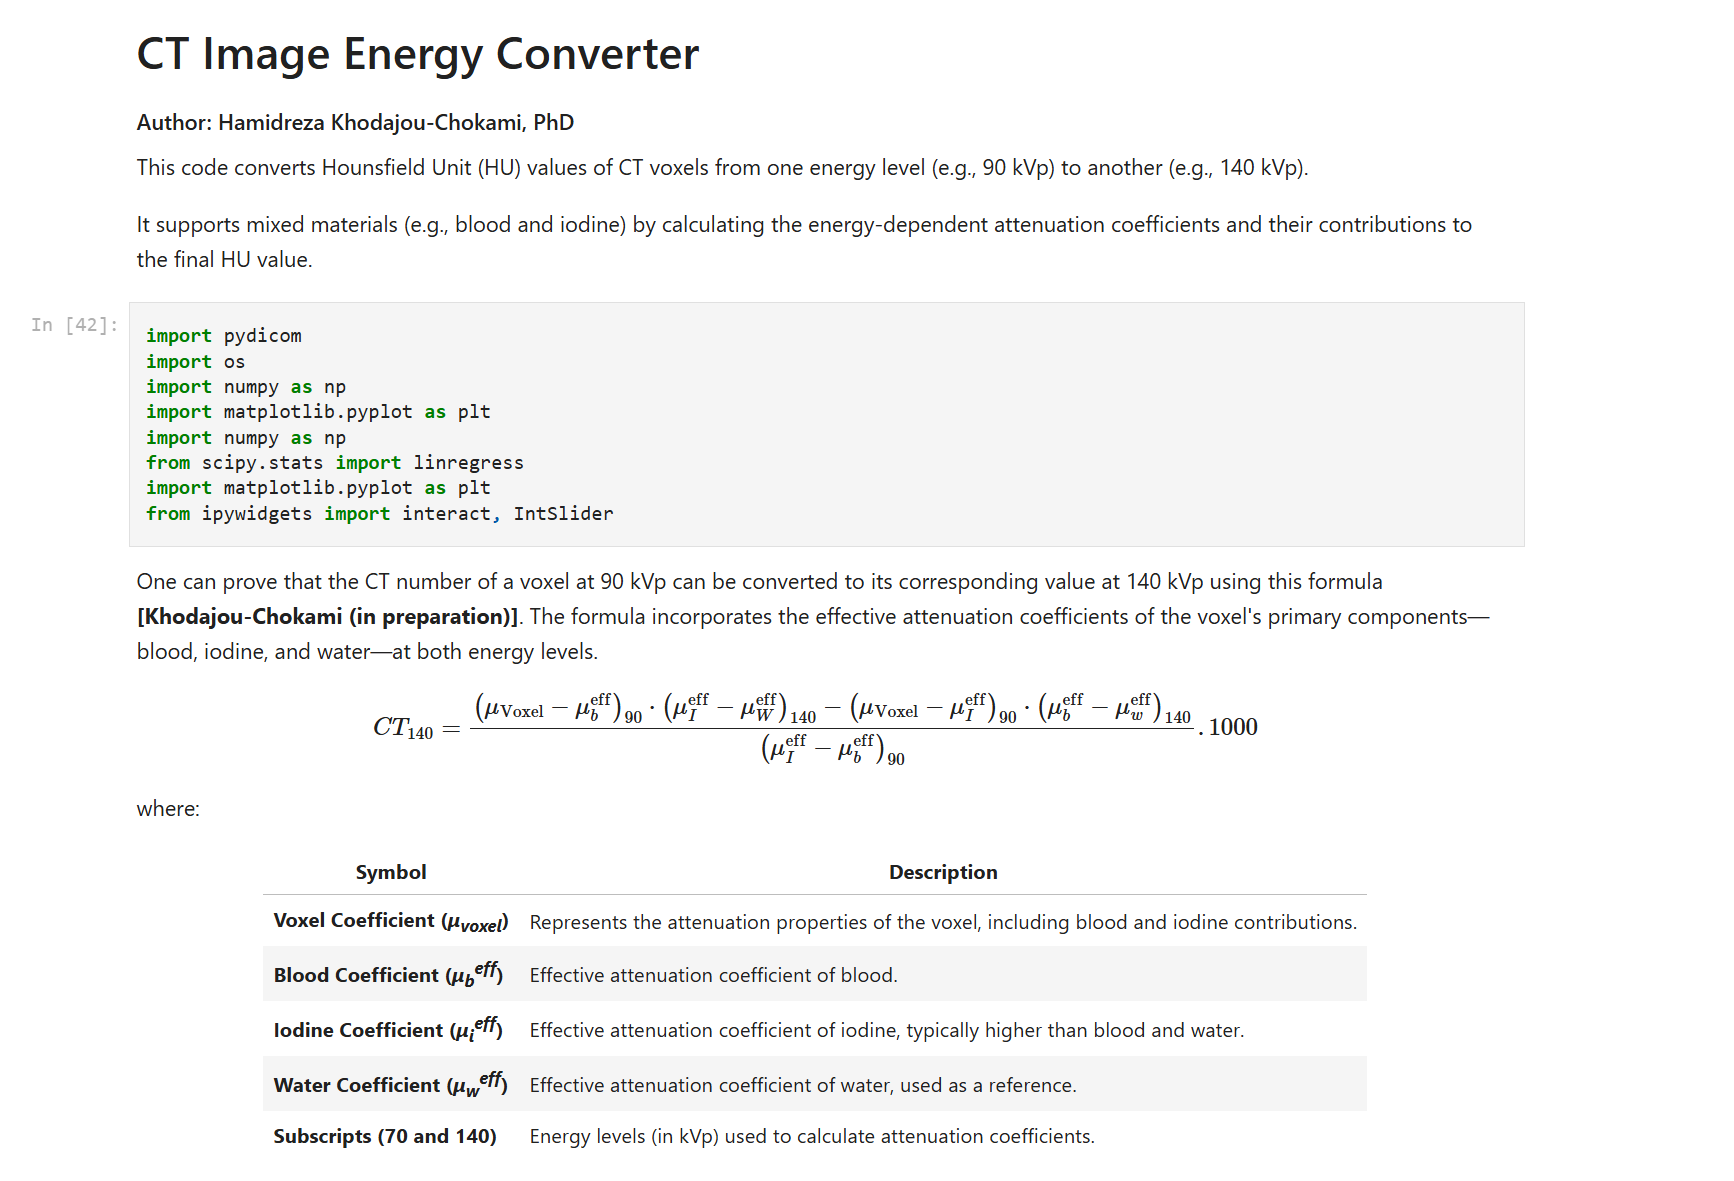

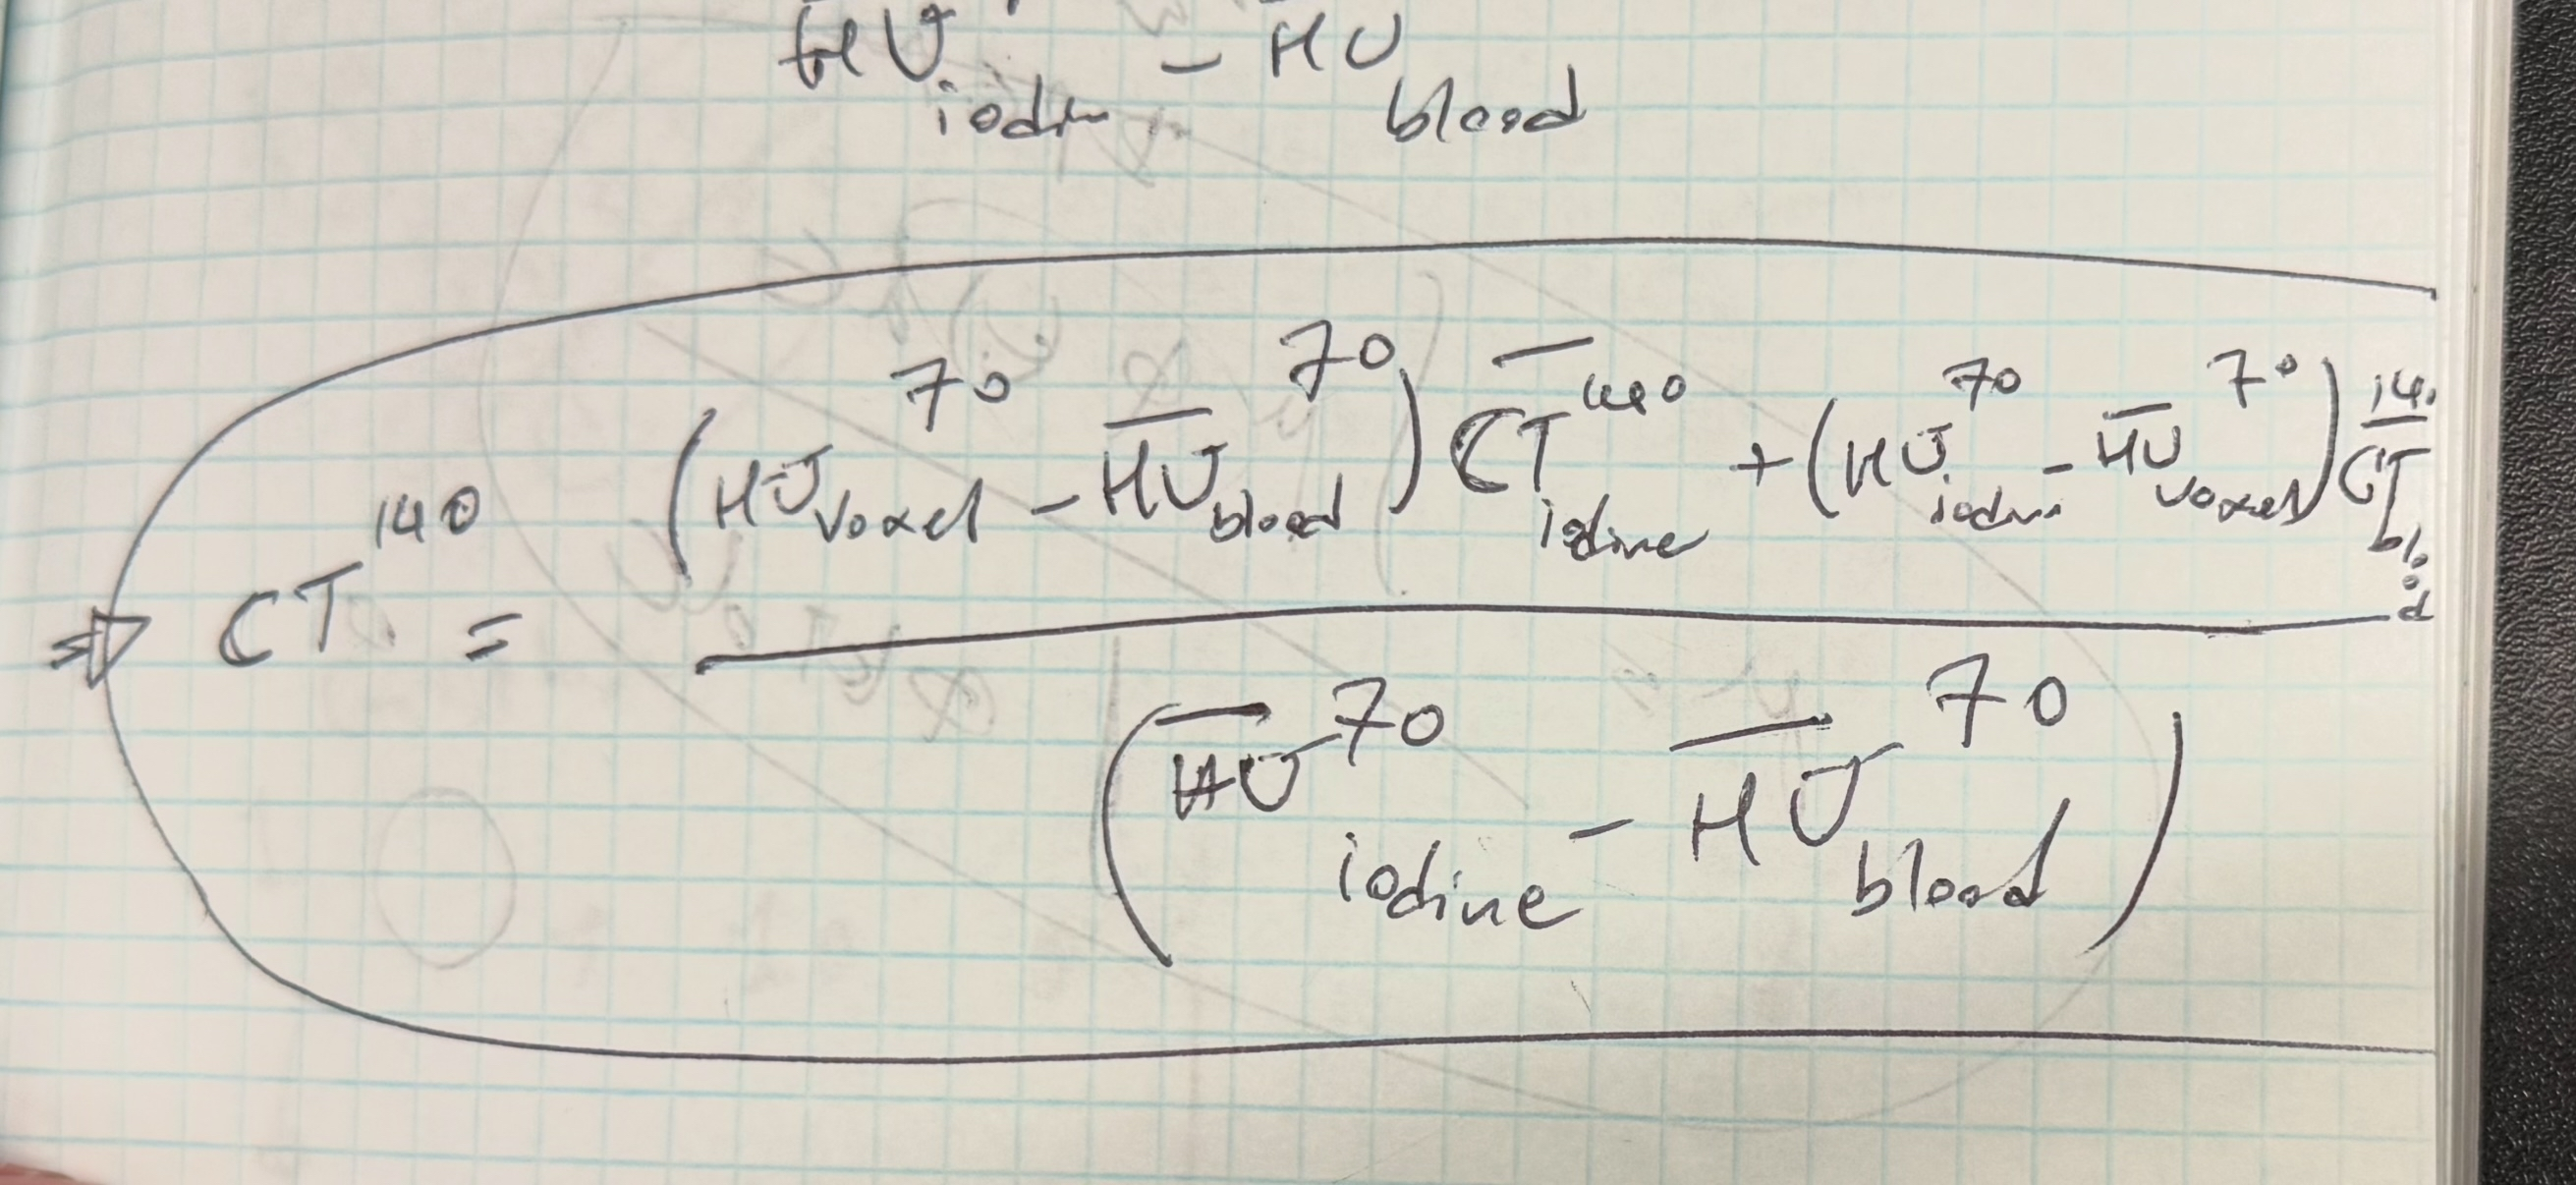

In [ ]:

Blood_highE_HU = highE_analysis.measured_HUs_pca_iodine[1]
Blood_lowE_HU = lowE_analysis.measured_HUs_pca_iodine[1]
Iodine_lowE_HU = lowE_analysis.measured_HUs_pca_iodine[0]
Iodine_highE_HU = highE_analysis.measured_HUs_pca_iodine[0]


print(lowE_analysis.measured_HUs_pca_iodine, highE_analysis.measured_HUs_pca_iodine)

[954.1327   71.76157 807.568   663.7762  518.9695  372.17868 220.44164
 142.95273  95.55603] [534.368    64.31663 455.72296 380.41458 305.22293 226.74098 144.68106
 101.11111  75.80345]


In [ ]:
GT_HU = highE_analysis.measured_HUs_pca_iodine[2:9]

In [ ]:
CTcalc_HU = []
percenterror = []
for i in range(2,9):
    # print(lowE_analysis.measured_HUs_pca_iodine[i], highE_analysis.measured_HUs_pca_iodine[i])
    CT140 = ( (lowE_analysis.measured_HUs_pca_iodine[i] - Blood_lowE_HU)*Iodine_highE_HU + (Iodine_lowE_HU - lowE_analysis.measured_HUs_pca_iodine[i])*Blood_highE_HU ) / (Iodine_lowE_HU - Blood_lowE_HU)
    percerror = (CT140 - highE_analysis.measured_HUs_pca_iodine[i])/highE_analysis.measured_HUs_pca_iodine[i]*100
    CTcalc_HU.append(CT140)
    percenterror.append(percerror)

In [ ]:
print(percenterror)
print(percenterror[9:None:-1])

[0.12463562889024615, -0.19020610488951206, -0.8755647577345371, -1.0531775653362274, -0.8021141402423382, 1.117624994367361, 1.5682823956012726]
[1.5682823956012726, 1.117624994367361, -0.8021141402423382, -1.0531775653362274, -0.8755647577345371, -0.19020610488951206, 0.12463562889024615]


In [ ]:
CT140 = ( (IodineBlood_lowE_HU - Blood_lowE_HU)*Iodine_highE_HU + (Iodine_lowE_HU - IodineBlood_lowE_HU)*Blood_highE_HU ) / (Iodine_lowE_HU - Blood_lowE_HU)

percerror = (CT140 - IodineBlood_highE_HU)/IodineBlood_highE_HU*100

print('HU of mixture at 140 kVp =', IodineBlood_highE_HU)
print('Calculation of CT number =', CT140)
print('Percent error =', percerror,'%')

HU of mixture at 140 kVp = 79.8755
Calculation of CT number = 79.17457
Percent error = -0.8775347843766212 %


In [ ]:
x_pos

array([], dtype=int64)

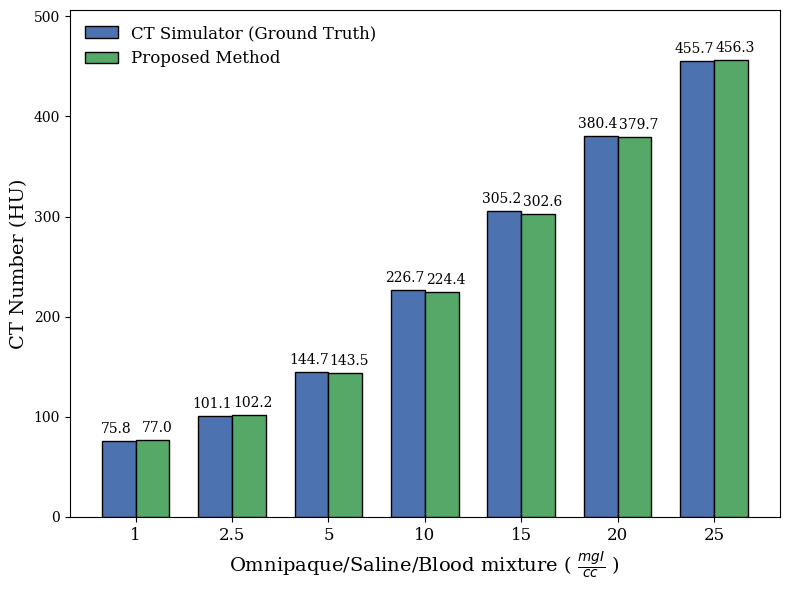

In [ ]:
bar_width = 0.35
plt.rcParams['font.family'] = 'serif'

# Create the bar plot
# Generate x-axis positions for the bars
x_pos = np.arange(len(CTcalc_HU))


fig, ax = plt.subplots(figsize=(8, 6))

# Ground Truth bars
bars = ax.bar(x_pos, GT_HU[9:None:-1], bar_width, color='#4C72B0', label='CT Simulator (Ground Truth)', edgecolor='black')
for bar, value in zip(bars, GT_HU[9:None:-1]):
    ax.text(bar.get_x() + bar.get_width() / 2.4, bar.get_height() + 5, str(round(value, 1)),
            ha='center', va='bottom', fontsize=10)

# Proposed Method bars
bars = ax.bar(x_pos + bar_width, CTcalc_HU[9:None:-1], bar_width, color='#55A868', label='Proposed Method', edgecolor='black')
for bar, value in zip(bars, CTcalc_HU[9:None:-1]):
    ax.text(bar.get_x() + bar.get_width() / 1.6, bar.get_height() + 5, str(round(value, 1)),
            ha='center', va='bottom', fontsize=10)


ax.set_xlabel(r'Omnipaque/Saline/Blood mixture ( $\frac{mgI}{cc}$ )', fontsize=14)
ax.set_ylabel('CT Number (HU)', fontsize=14)

ax.set_xticks(x_pos + bar_width / 2)
ax.set_xticklabels(['1', '2.5' , '5', '10', '15', '20', '25'], fontsize=12)
# plt.xticks(x_pos + bar_width / 2, ['25', '20', '15', '10', '5', '2.5', '1'], fontsize=14)


# Add legend
ax.legend(fontsize=12, loc='upper left', frameon=False)

# ignore spines initially removed but Hamid wanted it to show
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
# ax.set_xlim([-0.5, len(CTcalc_HU),0.5])  # Adjusts the x-axis to extend beyond the first and last bar
ax.set_ylim([0, max(max(GT_HU), max(CTcalc_HU)) + 50])  # Extends y-axis a bit beyond the highest bar
# Light gridlines for y-axis



plt.tight_layout()
plt.savefig("kVp_Converter_Bar_Plot_HighRes.pdf", dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-31-e6e4ded43c57>:30: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.yaxis.grid(False, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)


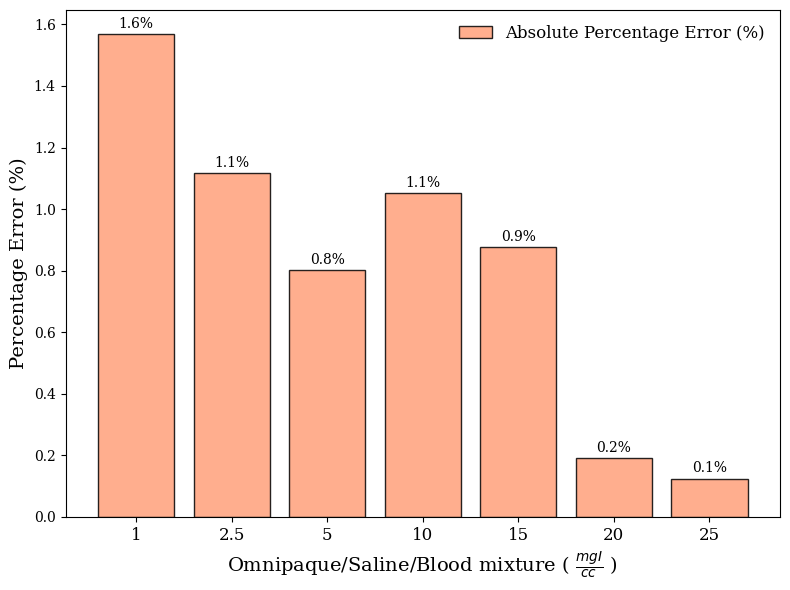

In [ ]:
percent_error = np.abs((CTcalc_HU - GT_HU) / GT_HU) * 100

x_pos = np.arange(len(GT_HU))

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x_pos, percent_error[9:None:-1], color='#FFA07A', alpha=0.85, label='Absolute Percentage Error (%)', edgecolor='black')


for bar, value in zip(bars, percent_error[9:None:-1]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.1f}%',
            ha='center', va='bottom', fontsize=10)


ax.set_xlabel(r'Omnipaque/Saline/Blood mixture ( $\frac{mgI}{cc}$ )', fontsize=14)
ax.set_ylabel('Percentage Error (%)', fontsize=14)


ax.set_xticks(x_pos)
ax.set_xticklabels(['1','2.5', '5', '10', '15', '20', '25'], fontsize=12)
# plt.xticks(x_pos, ['25', '20', '15', '10', '5', '2.5', '1'], fontsize=12)


# Add legend
ax.legend(fontsize=12, loc='upper right', frameon=False)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


ax.yaxis.grid(False, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.grid(False)
ax.set_axisbelow(True)

# Tight layout and save as high-resolution PDF
plt.tight_layout()
plt.savefig("Percent_Error_Bar_Plot_HighRes.pdf", dpi=300)
plt.show()


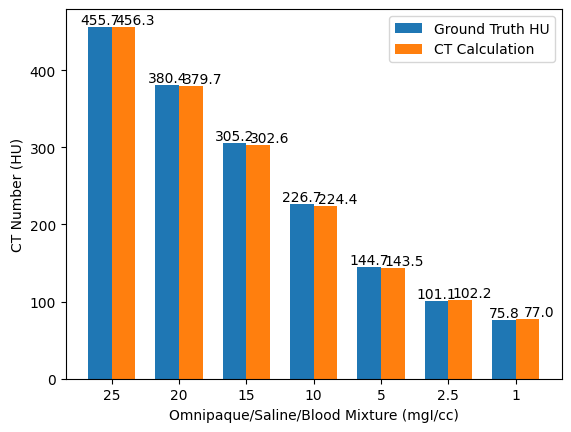

In [ ]:
#Example code to make a bar graph
# Width of each bar
bar_width = 0.35

# Generate x-axis positions for the bars
x_pos = np.arange(len(CTCalc))

# Create the bar plot
bars = plt.bar(x_pos, highE_analysis.measured_HUs_pca_iodine[2:9], bar_width, label='Ground Truth HU')
for bar, value in zip(bars, highE_analysis.measured_HUs_pca_iodine[2:9]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(value,1)), ha='center', va='bottom')

bars = plt.bar(x_pos + bar_width, CTCalc, bar_width, label='CT Calculation')
for bar, value in zip(bars, CTCalc):
    plt.text(bar.get_x() + bar.get_width() / 1, bar.get_height(), str(round(value,1)), ha='center', va='bottom')
# plt.errorbar(x_pos + bar_width, measured_I, fmt=".", yerr = measuredStd_I, color = 'black')
# Add labels and title
plt.xlabel('Omnipaque/Saline/Blood Mixture (mgI/cc)')
plt.ylabel('CT Number (HU)')
# plt.title('Omnipaque')

# Customize x-axis ticks
plt.xticks(x_pos + bar_width / 2, ['25', '20', '15', '10', '5', '2.5', '1'])

# Add legend
plt.legend()

# Display the plot
plt.savefig("kVp_Converter_Bar_Plot.pdf")

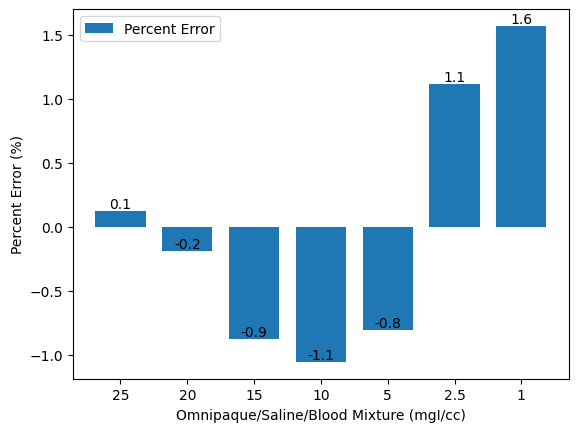

In [ ]:
#Example code to make a bar graph
# Width of each bar
bar_width = 0.75

# Generate x-axis positions for the bars
x_pos = np.arange(len(percenterror))

# Create the bar plot
bars = plt.bar(x_pos, percenterror, bar_width, label='Percent Error')
for bar, value in zip(bars, percenterror):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(round(value,1)), ha='center', va='bottom')

# plt.errorbar(x_pos + bar_width, measured_I, fmt=".", yerr = measuredStd_I, color = 'black')
# Add labels and title
plt.xlabel('Omnipaque/Saline/Blood Mixture (mgI/cc)')
plt.ylabel('Percent Error (%)')
# plt.title('Omnipaque')

# Customize x-axis ticks
plt.xticks(x_pos, ['25', '20', '15', '10', '5', '2.5', '1'])

# Add legend
plt.legend()

# Display the plot
plt.savefig("kVp_Converter_Error_Bar_Plot.pdf")

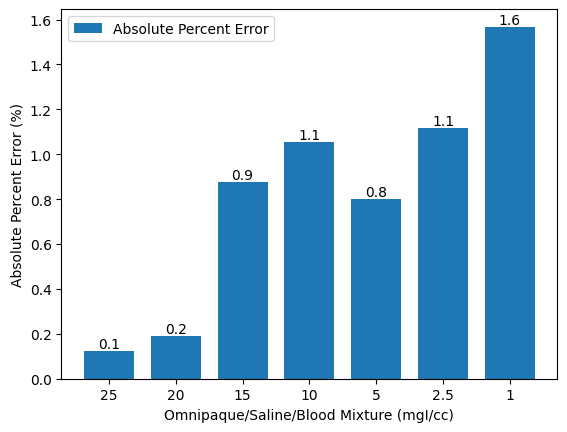

In [ ]:
abspercerror = np.abs(percenterror)
#Example code to make a bar graph
# Width of each bar
bar_width = 0.75

# Generate x-axis positions for the bars
x_pos = np.arange(len(percenterror))

# Create the bar plot
bars = plt.bar(x_pos, abspercerror, bar_width, label='Absolute Percent Error')
for bar, value in zip(bars, abspercerror):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(round(value,1)), ha='center', va='bottom')

# plt.errorbar(x_pos + bar_width, measured_I, fmt=".", yerr = measuredStd_I, color = 'black')
# Add labels and title
plt.xlabel('Omnipaque/Saline/Blood Mixture (mgI/cc)')
plt.ylabel('Absolute Percent Error (%)')
# plt.title('Omnipaque')

# Customize x-axis ticks
plt.xticks(x_pos, ['25', '20', '15', '10', '5', '2.5', '1'])

# Add legend
plt.legend()

# Display the plot
plt.savefig("kVp_Converter_Error_Bar_Plot.pdf")

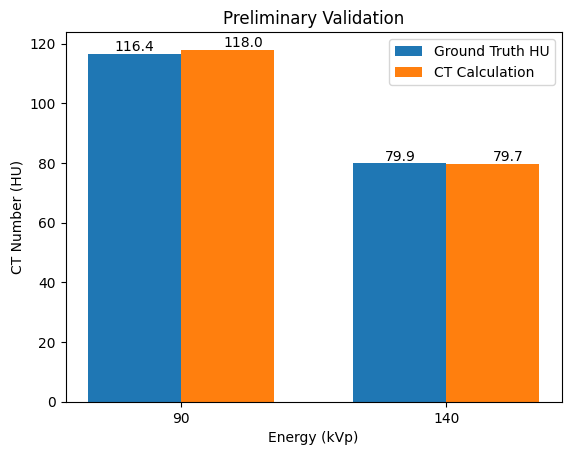

In [ ]:
#Example code to make a bar graph
# Width of each bar
bar_width = 0.35

# Generate x-axis positions for the bars
x_pos = np.arange(len(CTcalc_HU))

# Create the bar plot
bars = plt.bar(x_pos, GT_HU, bar_width, label='Ground Truth HU')
for bar, value in zip(bars, GT_HU):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(value,1)), ha='center', va='bottom')

bars = plt.bar(x_pos + bar_width, CTcalc_HU, bar_width, label='CT Calculation')
for bar, value in zip(bars, CTcalc_HU):
    plt.text(bar.get_x() + bar.get_width() / 1.5, bar.get_height(), str(round(value,1)), ha='center', va='bottom')
# plt.errorbar(x_pos + bar_width, measured_I, fmt=".", yerr = measuredStd_I, color = 'black')
# Add labels and title
plt.xlabel('Energy (kVp)')
plt.ylabel('CT Number (HU)')
plt.title('Preliminary Validation')

# Customize x-axis ticks
plt.xticks(x_pos + bar_width / 2, ['90', '140'])

# Add legend
plt.legend()

# Display the plot
plt.savefig("kVp_Converter_Bar_Plot.pdf")